# Лекция 3
## Модели ARIMA и GARCH

In [8]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [11]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## В чем суть

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

## Белый шум и случайные блуждания

Первая модель - которую мы рассмотрим - белый шум.

$y_t = E$

Results of Dickey-Fuller Test:
Test Statistic                 -29.628969
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


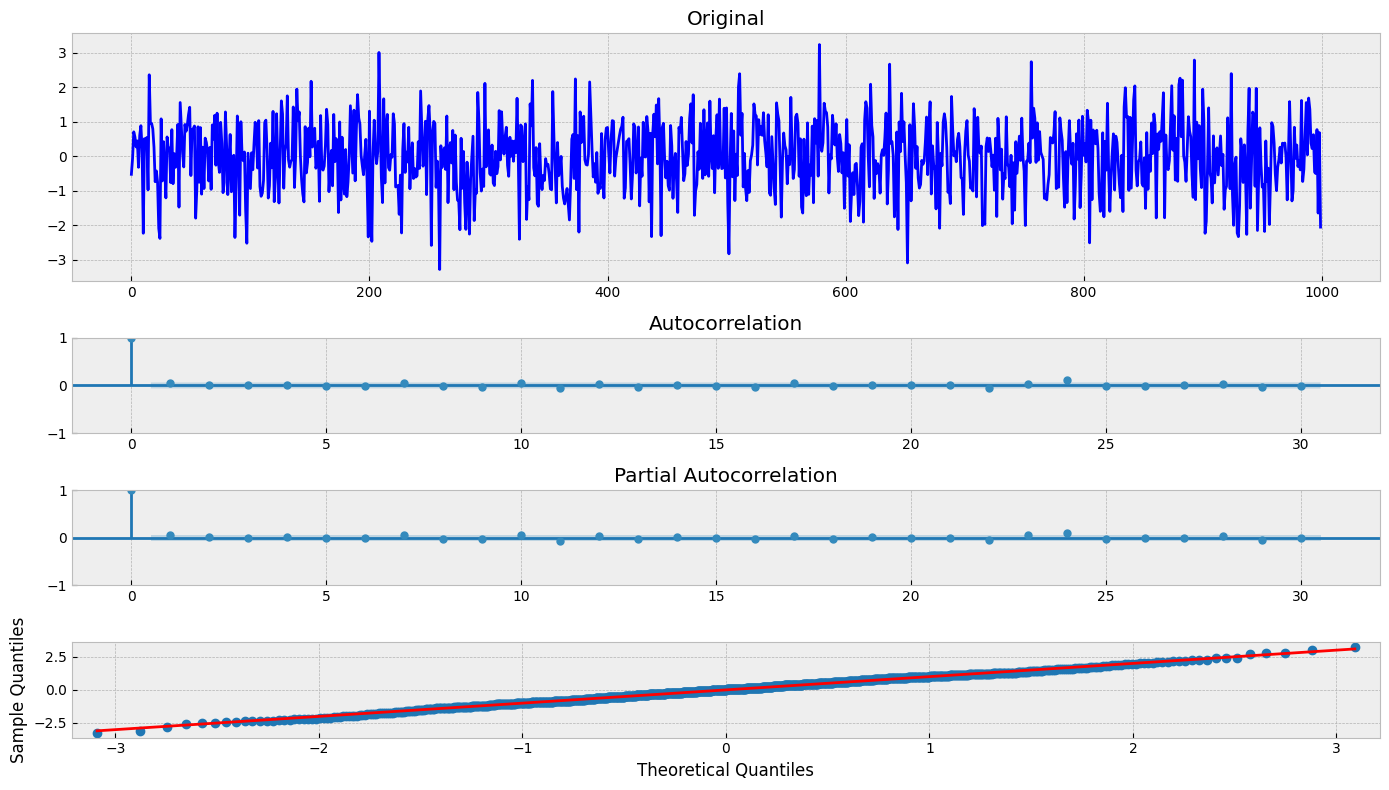

In [12]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [13]:
# np.sort(randser)

## Random Walk

### Следующая модель - это модель случайного блуждания.

$y_t = y_{t-1} + \epsilon_{t}$

где $\epsilon_{t}$ - белый шум
Особенность случайного блуждания в том, что он не стационарен, т.е. его свойства меняются со временем и предсказать его невозможно

## Практика - реализуйте процесс случайного блуждания

In [14]:
n_samples = 100

In [15]:
eps = np.random.normal(size=n_samples)
x = [0 + eps[0]]
for i in range(1, n_samples):
    x.append(x[i-1] + eps[i])

In [16]:
x = np.array(x)

Results of Dickey-Fuller Test:
Test Statistic                 -2.527549
p-value                         0.108914
#Lags Used                      2.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


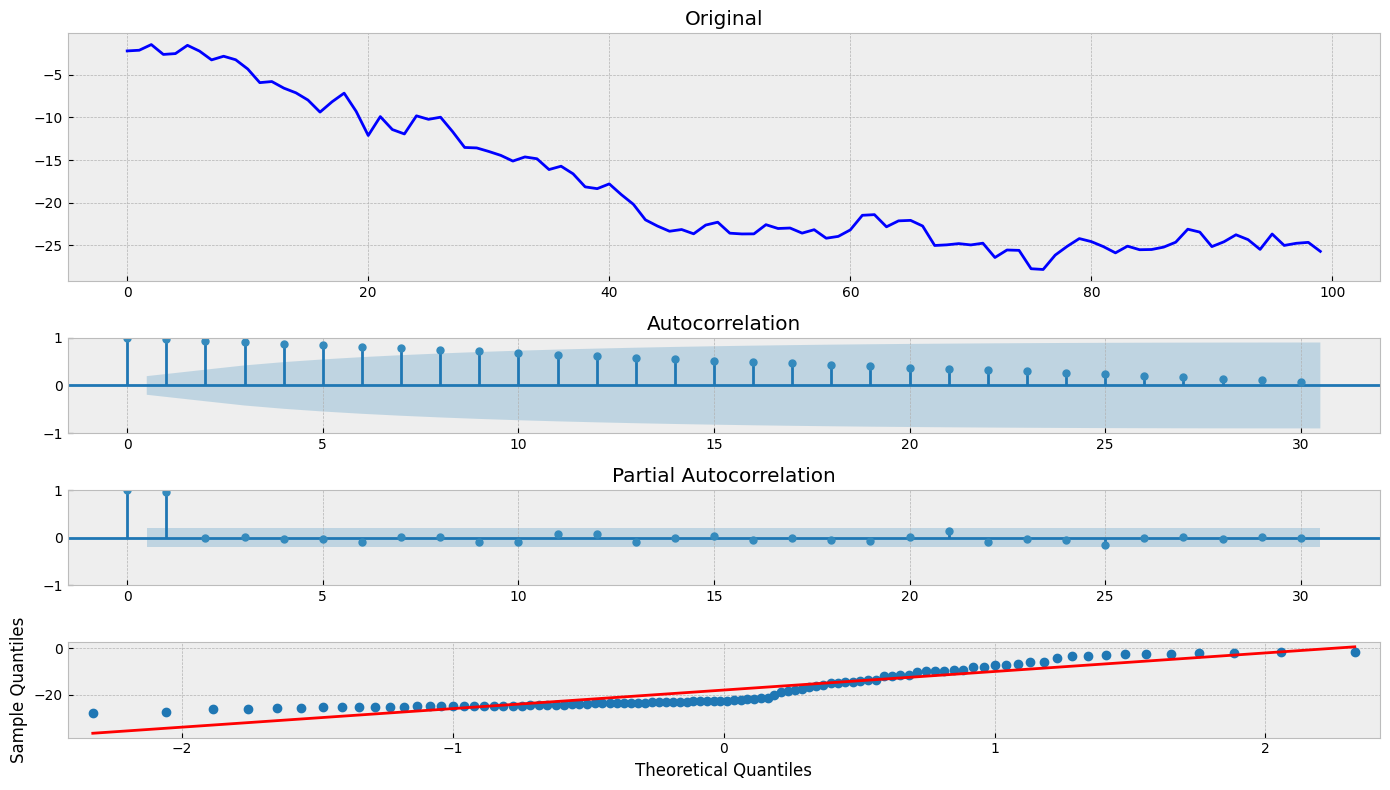

In [17]:
tsplot(x, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                  -3.217306
p-value                          0.019005
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


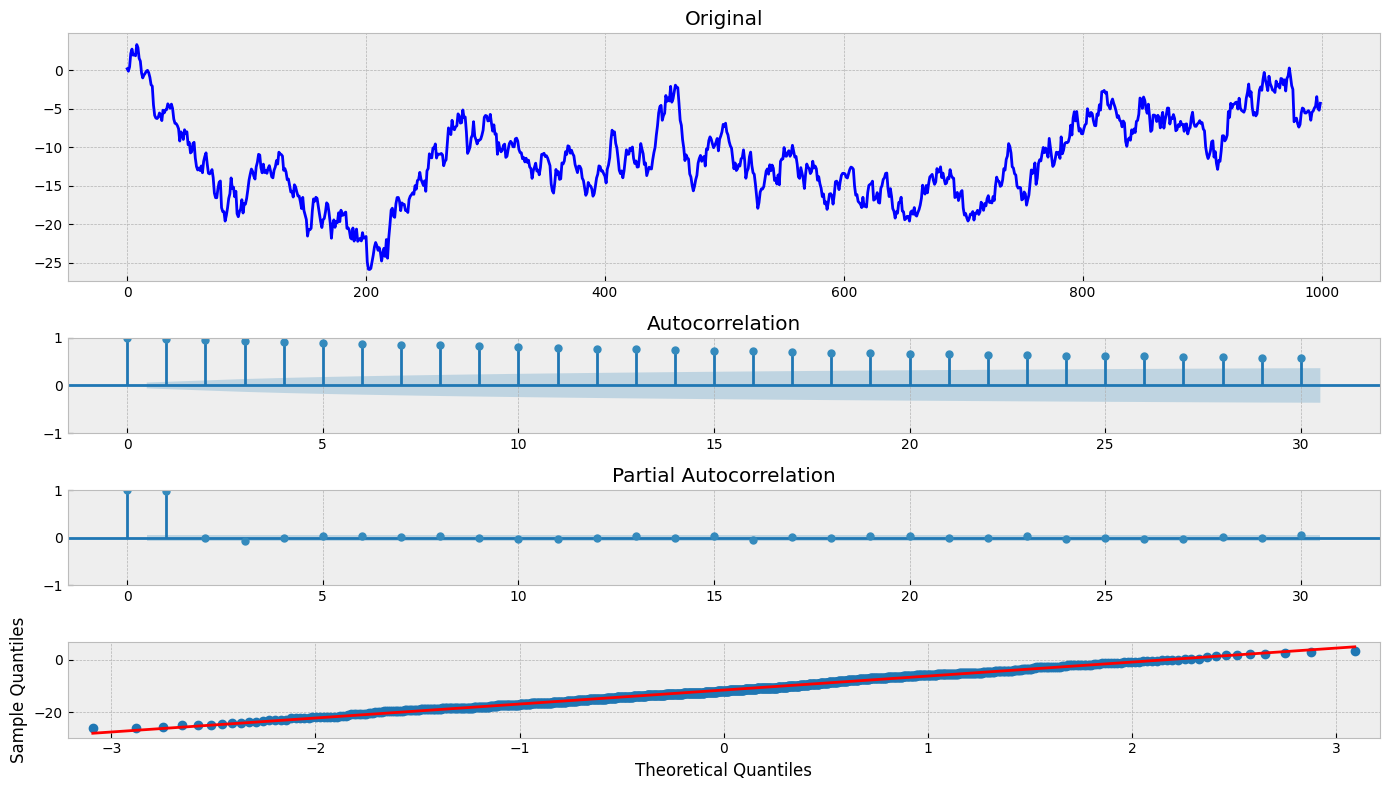

In [18]:
x = np.random.normal(size=1000)
x = np.cumsum(x)
tsplot(x, lags=30)

Давайте проверим, подходит ли модель случайного блуждания под сгенерированные данные. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                 -21.265484
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    997.000000
Critical Value (1%)             -3.436926
Critical Value (5%)             -2.864443
Critical Value (10%)            -2.568316
dtype: float64


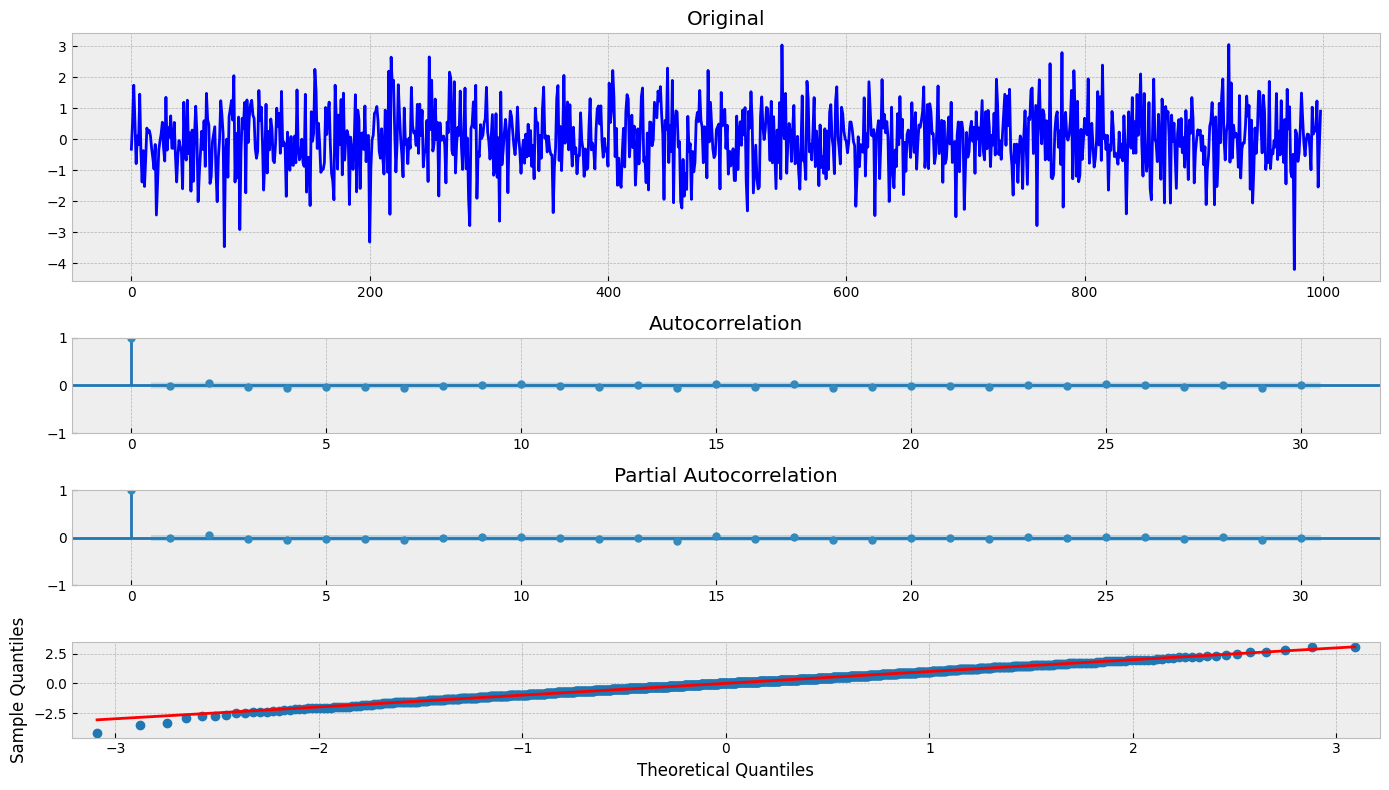

In [19]:
tsplot(np.diff(x), lags=30)

Ура! Однако для реальных данных такой модели конечно не достаточно.

# AR(p)

Авторегрессионная модель — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда. Авторегрессионный процесс порядка p (AR(p)-процесс) определяется следующим образом

$y_t = c + \sum_{i=1}^P a_i y_{t-i} + \epsilon_t$

где $\epsilon_t$ - белый шум

Сделаем симуляцию процесса AR(1) и посмотрим, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -1.877613e+01
p-value                        2.024692e-30
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


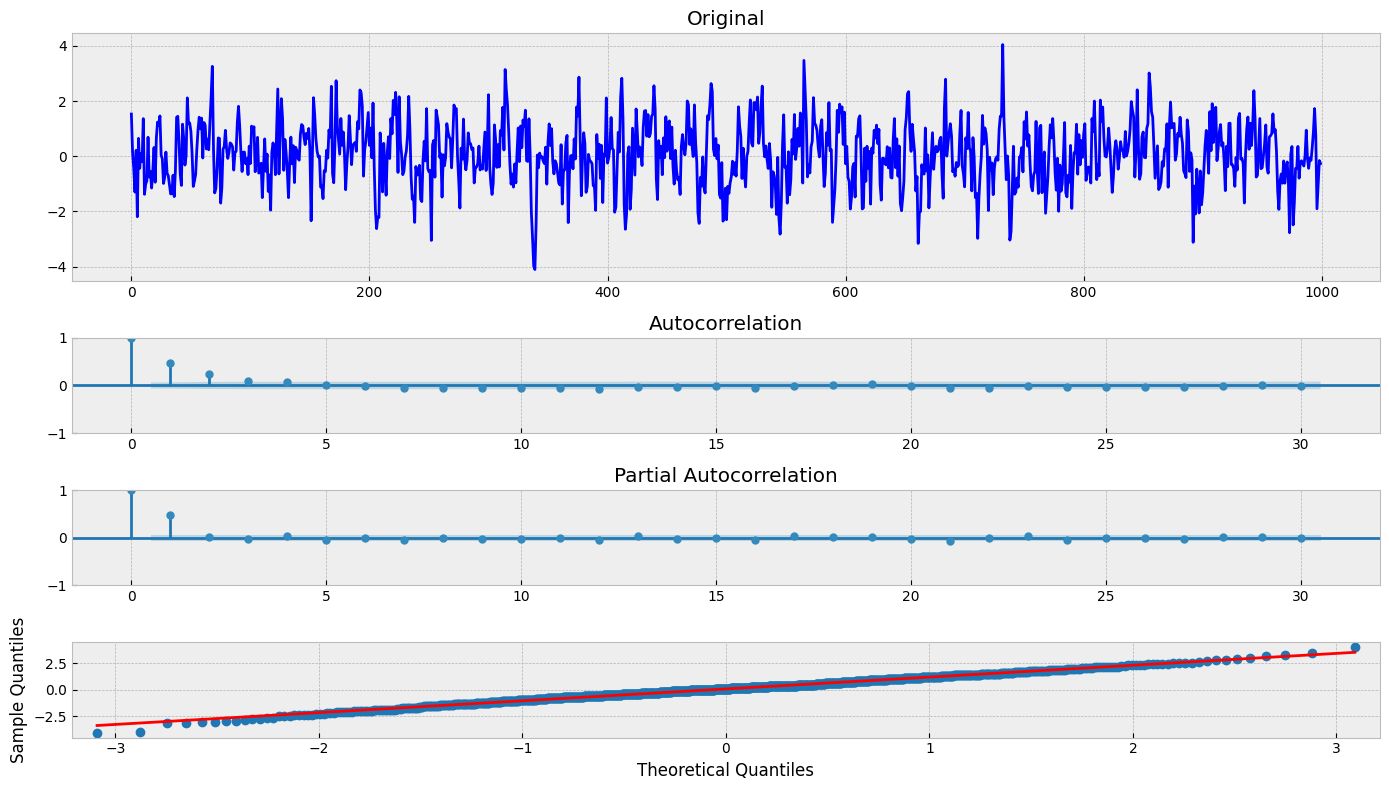

In [20]:
np.random.seed(1)
n_samples = int(1000)
a = 0.5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=30)

In [23]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

# Определяем диапазон лагов для тестирования
max_lag = 30
aic_values = []
lags = range(1, max_lag + 1)

# Пробуем разные значения лагов и сохраняем AIC для каждого
for lag in lags:
    model = AutoReg(x, lags=lag, trend='n').fit()
    aic_values.append(model.aic)

# Находим лаг с минимальным значением AIC
best_lag = lags[np.argmin(aic_values)]

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(model.params[1], best_lag))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))



alpha estimate: 0.01354 | best lag order = 29

true alpha = 0.5 | true order = 1


In [ ]:
mdl.params

array([ 0.48929667,  0.01353885, -0.03605199,  0.04222394, -0.02761742,
        0.02072129, -0.03852563, -0.00482808, -0.01617324, -0.01897093,
        0.02371592, -0.07318115,  0.04391756, -0.02405411,  0.01962497,
       -0.05519711,  0.03243137,  0.00134449,  0.0353356 , -0.00077707,
       -0.06083239, -0.02799997,  0.06480725, -0.05240768, -0.00741525,
        0.0140024 , -0.01573823,  0.00132314,  0.01982074, -0.01155067])

Results of Dickey-Fuller Test:
Test Statistic                 -31.197161
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    969.000000
Critical Value (1%)             -3.437116
Critical Value (5%)             -2.864527
Critical Value (10%)            -2.568361
dtype: float64


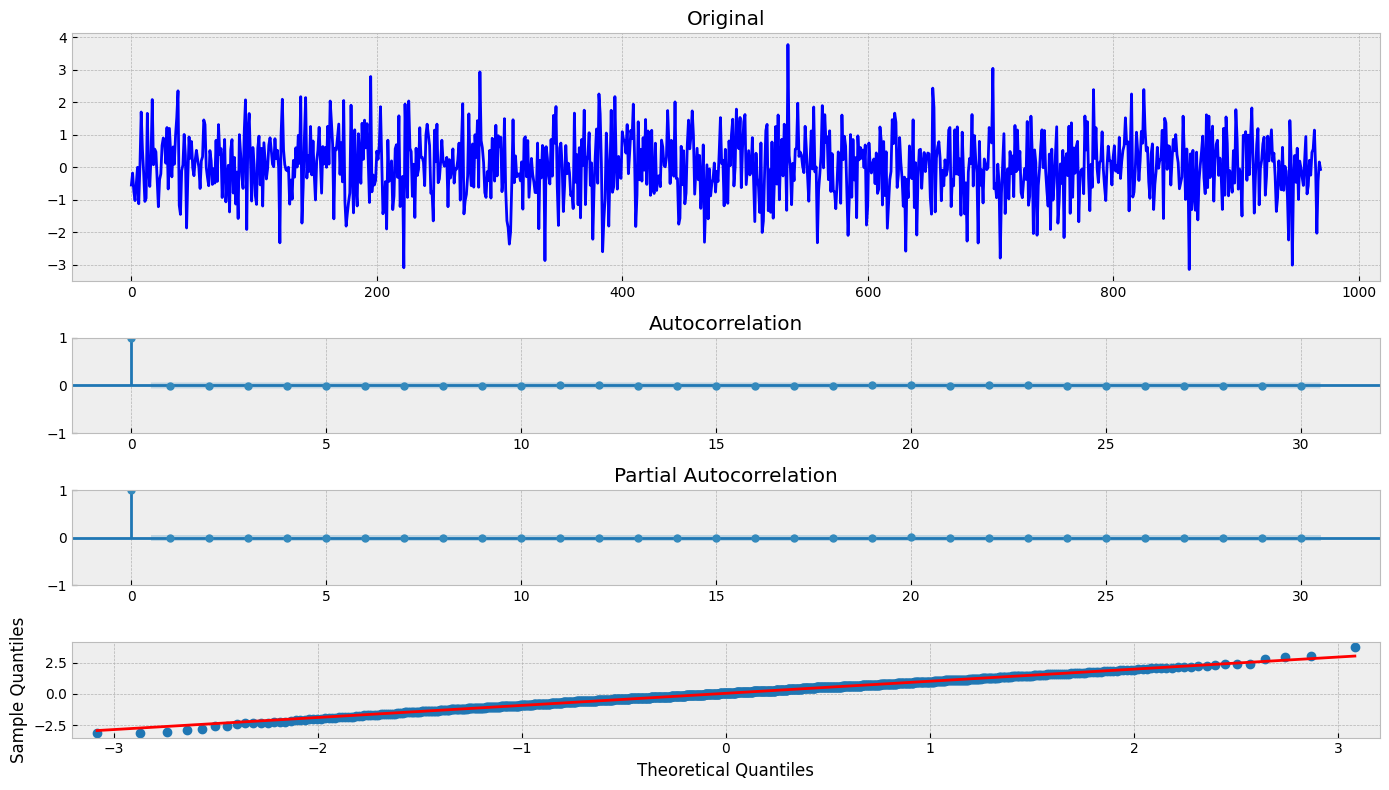

In [25]:
tsplot(mdl.resid, lags=30)

## Практика - сделайте симуляцию процесса AR(2) с параметрами 0.6 и 0.3 и посмотрите, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -6.988709e+00
p-value                        7.845875e-10
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64


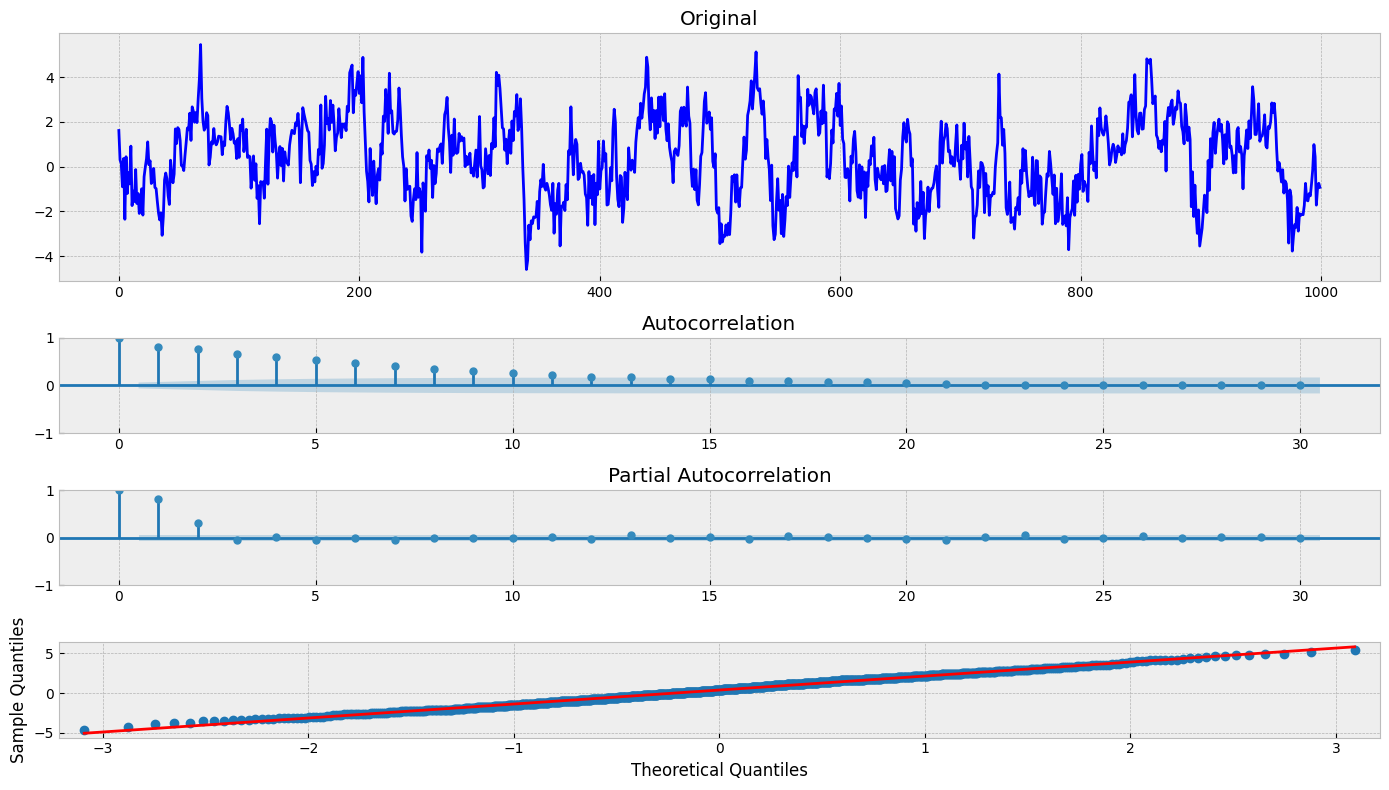

In [26]:
np.random.seed(1)
n_samples = int(1000)
a1 = 0.6
a2 = 0.3

x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a1*x[t-1] + a2*x[t-2] + w[t]
    
tsplot(x, lags=30)

In [28]:
mdl = AutoReg(x, lags=3, trend='n').fit()

print('\nalpha estimate: {}'.format(mdl.params))


alpha estimate: [ 0.57237228  0.34300155 -0.0433057 ]


Results of Dickey-Fuller Test:
Test Statistic                 -31.609276
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    996.000000
Critical Value (1%)             -3.436933
Critical Value (5%)             -2.864446
Critical Value (10%)            -2.568317
dtype: float64


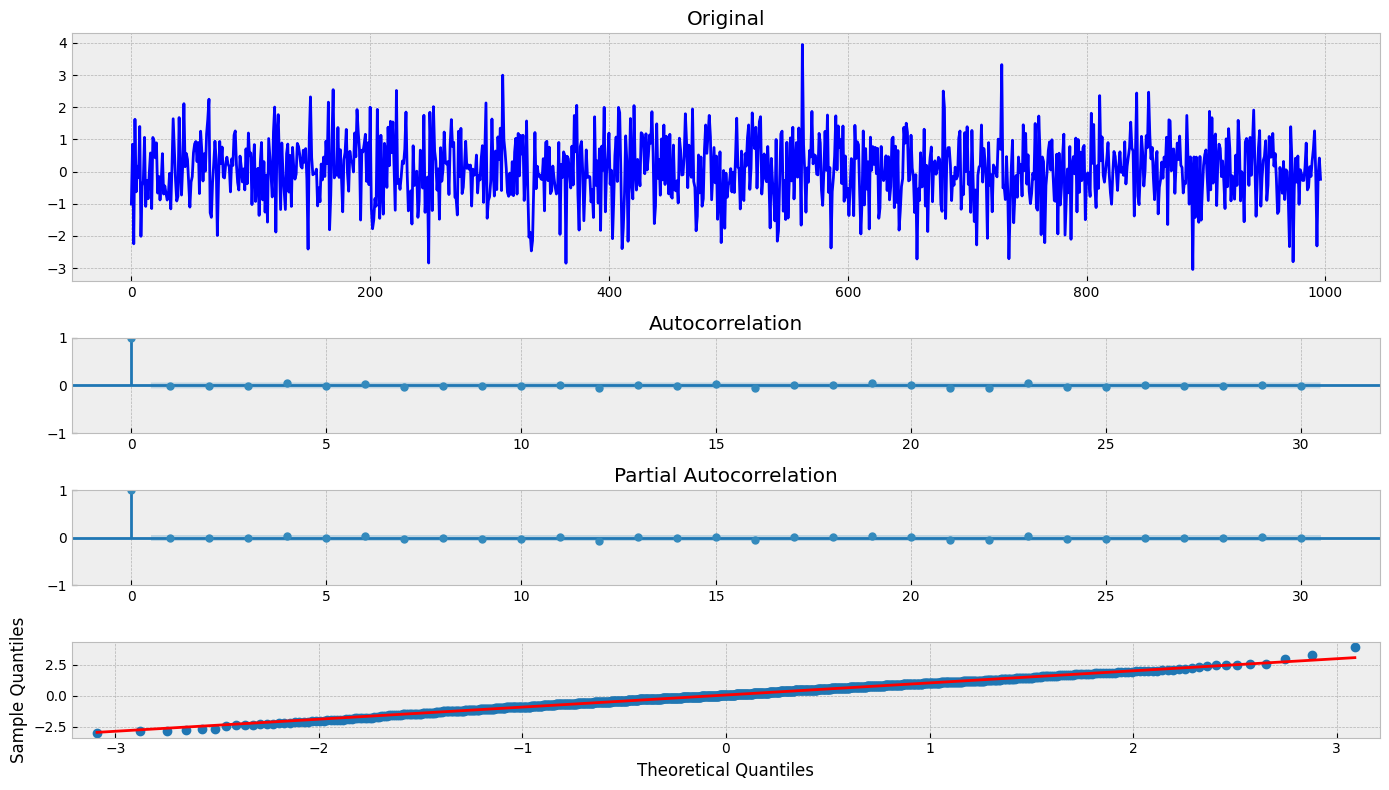

In [29]:
tsplot(mdl.resid, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


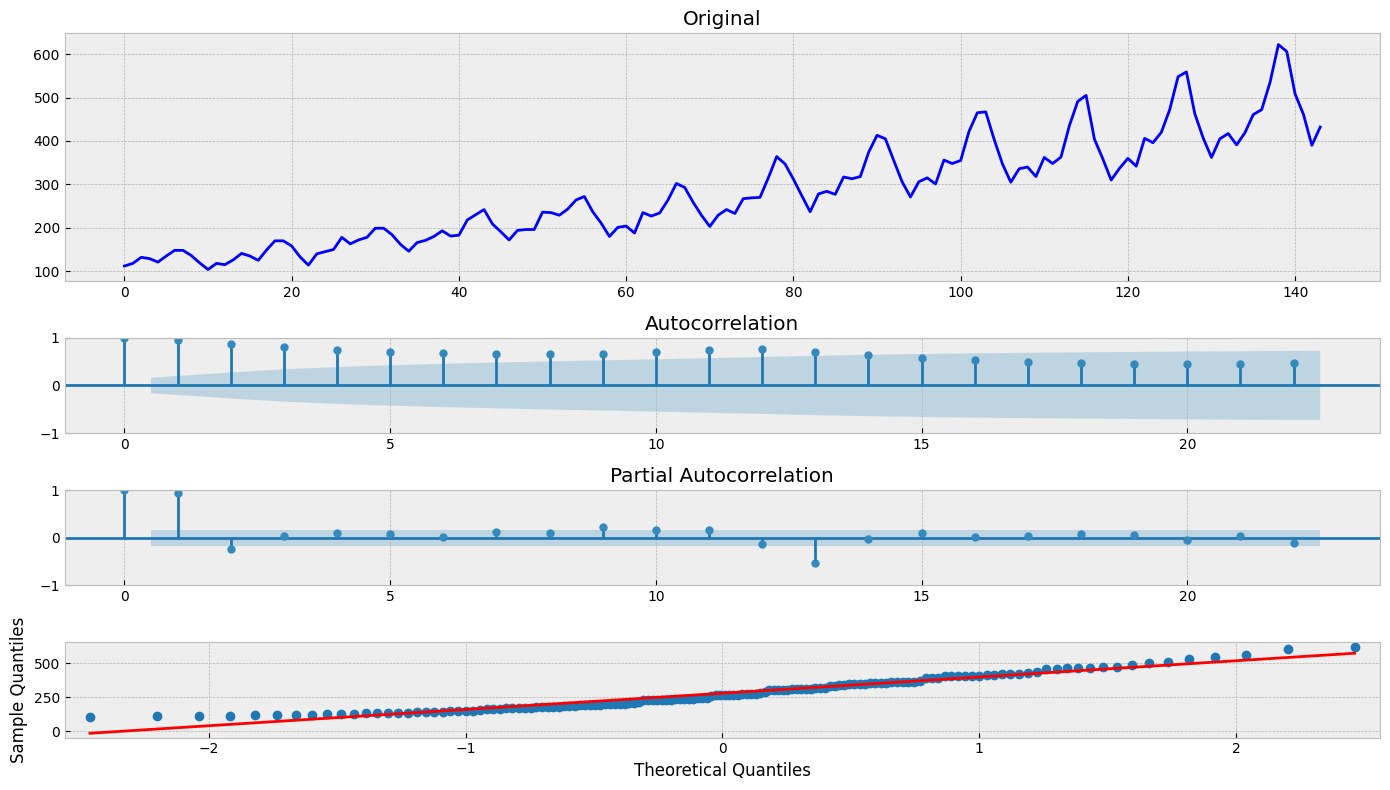

In [31]:
series = pd.read_csv("D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/Series/international-airline-passengers.csv")['Count']
tsplot(series)

In [32]:
series = pd.read_csv("D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


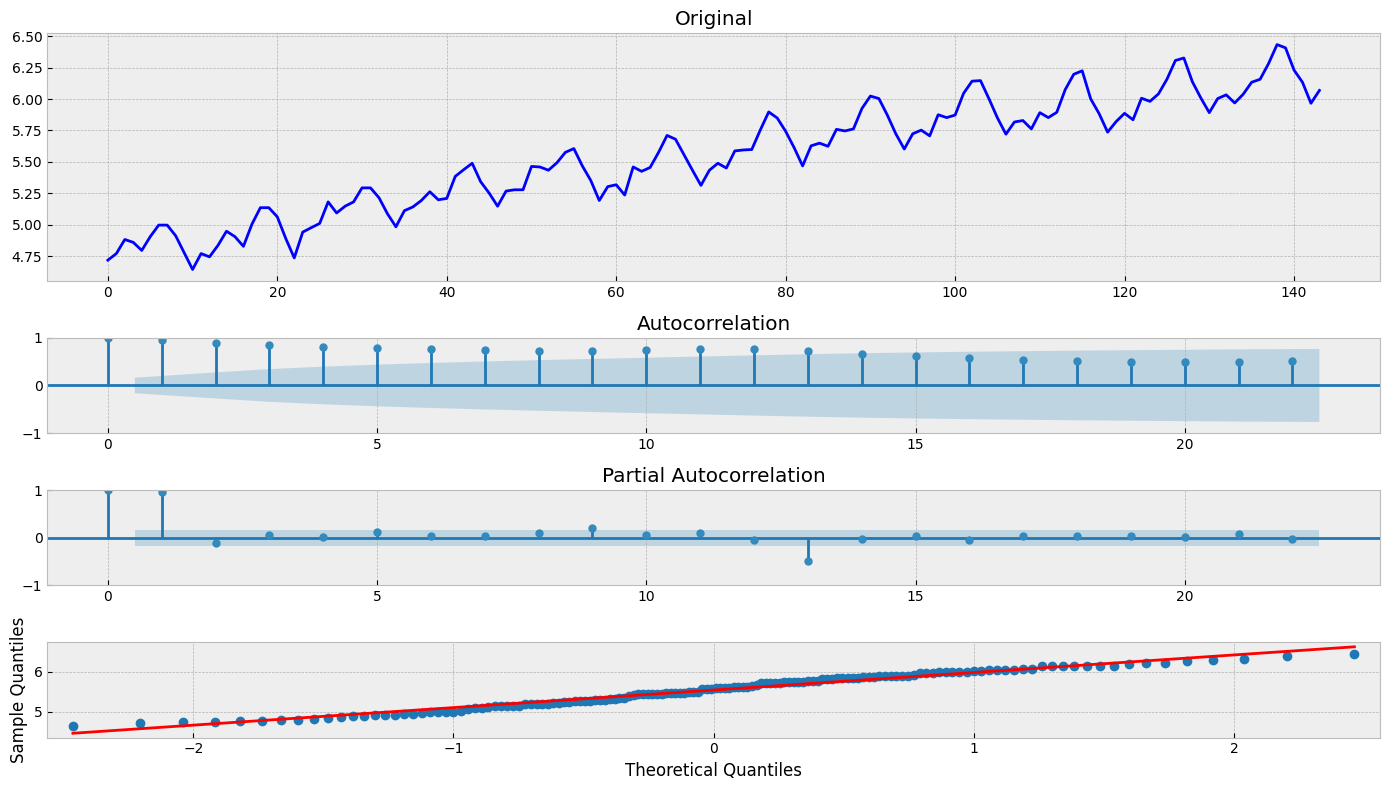

In [33]:
tsplot(series)

In [34]:
mdl = AutoReg(series, lags=30, trend='n').fit()
print(mdl.params)

[ 0.60590601  0.18874095  0.0221785  -0.08616652  0.23859304 -0.03601748
 -0.01720268 -0.0117881   0.21098772 -0.24808699 -0.01510498  0.57393113
 -0.22044979 -0.25262138  0.10637547 -0.0758579   0.00234903 -0.13490064
  0.12714321 -0.11291903 -0.06118884  0.11324869  0.19027473  0.21109168
 -0.16269641 -0.11860931  0.02496845  0.05505136 -0.12758193  0.01318311]


Results of Dickey-Fuller Test:
Test Statistic                -1.075062e+01
p-value                        2.671215e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


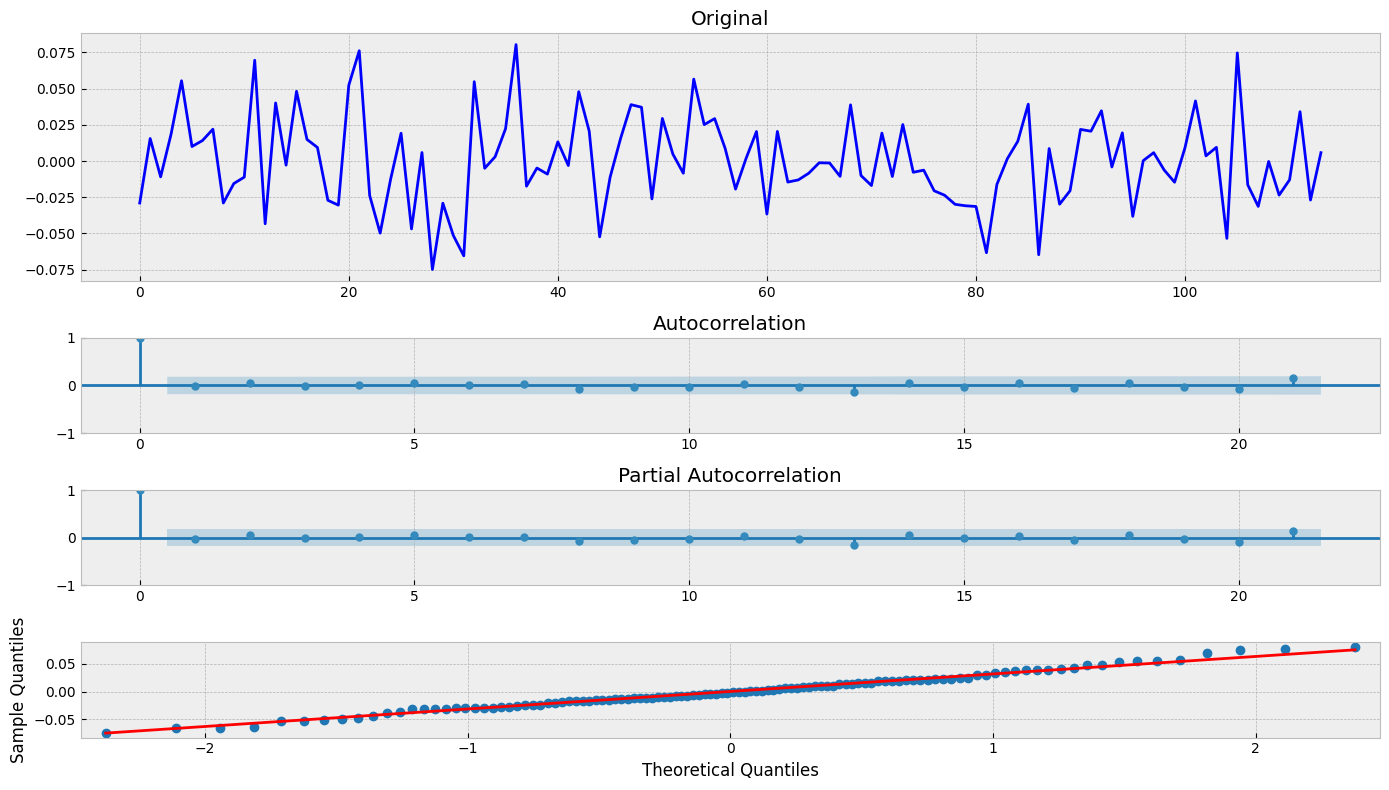

In [35]:
tsplot(mdl.resid)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


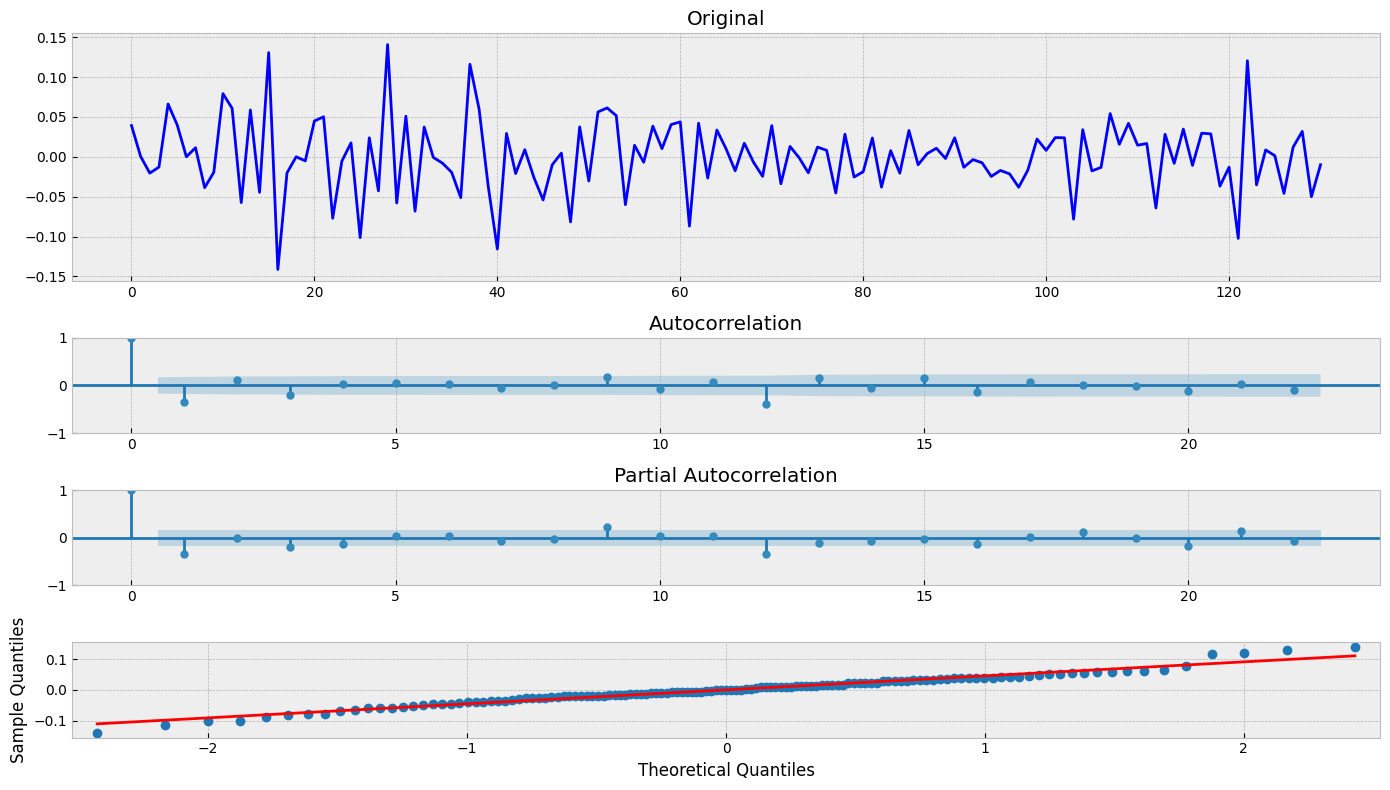

In [36]:
series_diffed = np.diff(series)
series_diffed = series_diffed[12:] - series_diffed[:-12]
tsplot(series_diffed)

In [38]:
mdl_diffed = AutoReg(series_diffed, lags=30, trend='n').fit()
print(mdl_diffed.params)

[-0.24199633 -0.02877249 -0.12233344 -0.17308552  0.08115879  0.02700866
 -0.01125829 -0.12120051  0.13239589 -0.10920431 -0.01823895 -0.40917866
 -0.20602706 -0.02895184  0.03634287 -0.18023461 -0.00152478  0.04072681
 -0.02253884 -0.16032218  0.08650478 -0.05422296  0.15304614 -0.15244598
 -0.10055533  0.06528697  0.02346241 -0.1344031   0.03162955 -0.05073549]


Results of Dickey-Fuller Test:
Test Statistic                -9.858099e+00
p-value                        4.305274e-17
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


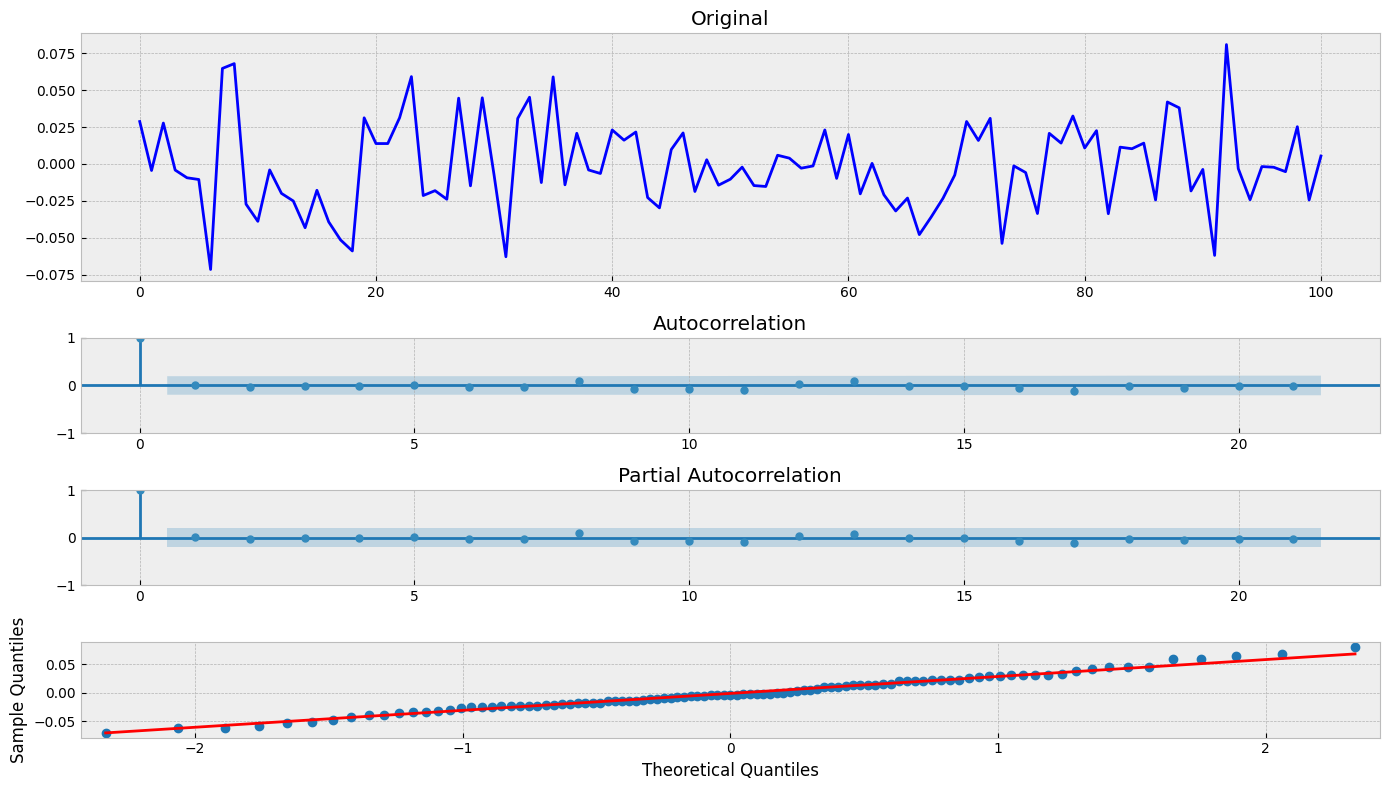

In [39]:
tsplot(mdl_diffed.resid)

## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

Сделаем симуляцию процесса ARMA

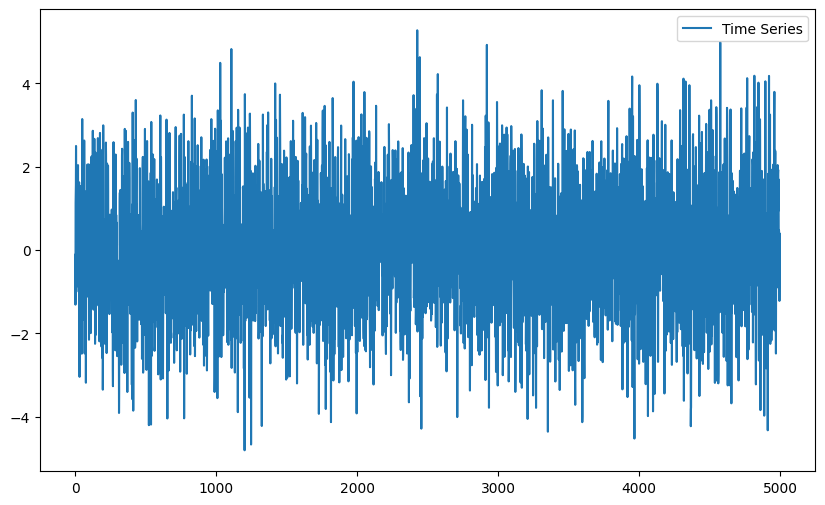

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7102.555
Date:                Tue, 11 Mar 2025   AIC                          14215.109
Time:                        14:44:54   BIC                          14247.695
Sample:                             0   HQIC                         14226.530
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3468      0.059      5.921      0.000       0.232       0.462
ar.L2         -0.2560      0.015    -16.838      0.000      -0.286      -0.226
ma.L1          0.6574      0.060     10.963      0.0

In [44]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
arma_process = ArmaProcess(ar, ma)

# Генерируем выборку ARMA
arma22 = arma_process.generate_sample(nsample=n, burnin=burn)

# Визуализируем временной ряд
def tsplot(y, lags=None):
    plt.figure(figsize=(10, 6))
    plt.plot(y, label='Time Series')
    plt.legend()
    plt.show()

tsplot(arma22, lags=max_lag)

# Подбираем модель ARIMA
mdl = ARIMA(arma22, order=(2, 0, 2), trend='n').fit()

print(mdl.summary())

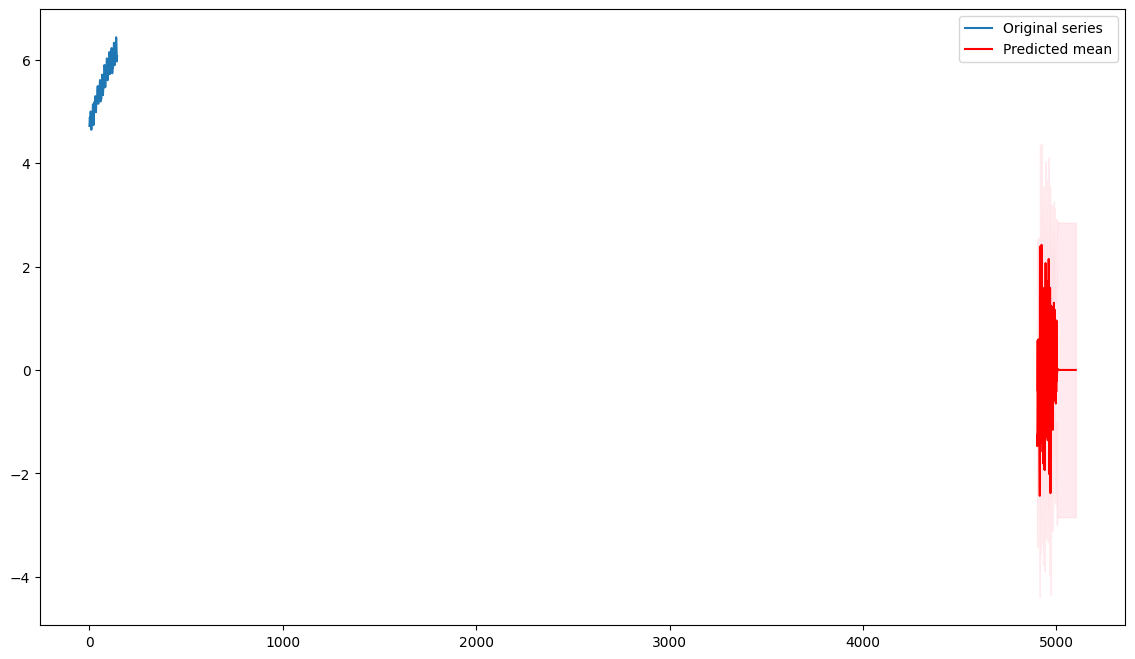

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Получаем прогнозируемые значения
pred = mdl.get_prediction(start=4900, end=5100)
predicted_mean = pred.predicted_mean
conf_int = pred.conf_int()

# Создаем Series из предсказанных значений и доверительного интервала
predicted_mean_series = pd.Series(predicted_mean, index=range(4900, 5101))
conf_int_df = pd.DataFrame(conf_int, columns=['lower_bound', 'upper_bound'], index=range(4900, 5101))

# Визуализируем прогнозируемые значения
plt.figure(figsize=(14, 8))
ax = plt.axes()

# Исходные данные
ax.plot(series, label='Original series')

# Прогнозируемые значения
ax.plot(predicted_mean_series, label='Predicted mean', color='r')

# Доверительный интервал
ax.fill_between(conf_int_df.index, conf_int_df['lower_bound'], conf_int_df['upper_bound'], color='pink', alpha=0.3)

ax.legend()
plt.show()


In [51]:
mdl.aic

np.float64(14215.1094027131)

p, q - гипер параметры => их можно подбирать. Как выбрать лучшие? AIC - Информационный критерий Акаике

## Практика! Реализуйте подбор гиперпараметров модели
Информационный критерий живет в вовзращаемом значении fit (у ARMA), чем меньше - тем лучше модель

In [52]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(maxlag=max_lag, method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i, j)))
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic:    inf | order: None


Применим модель ARMA к нашей TS

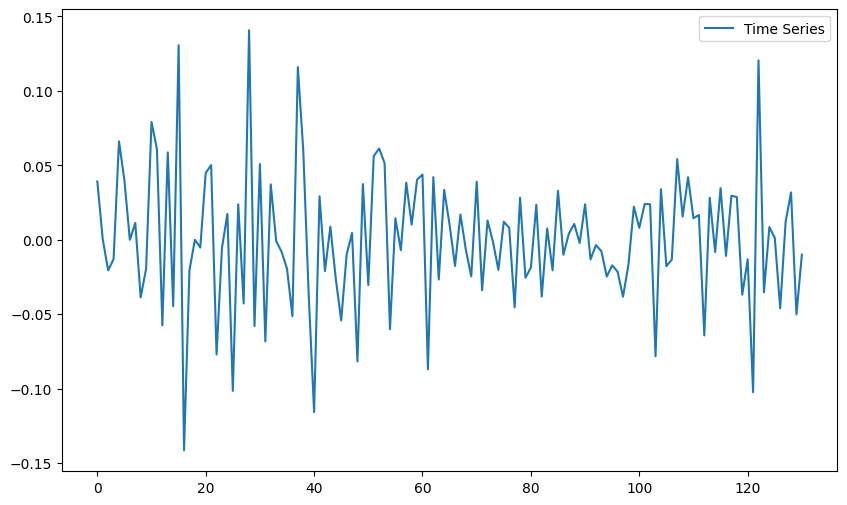

In [54]:
series = pd.read_csv("D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
tsplot(series)

In [55]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(series, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic:    inf | order: None


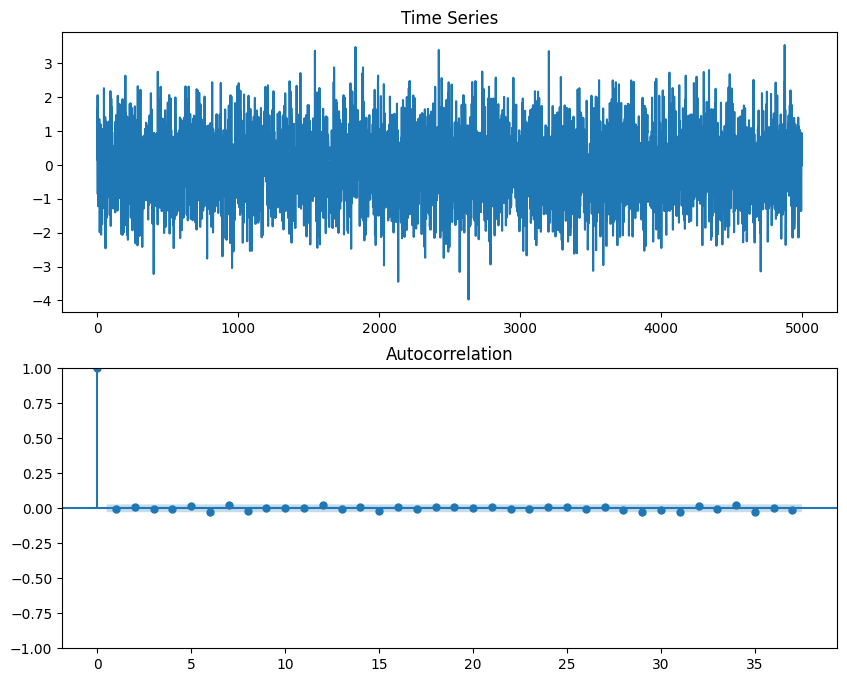

In [60]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as smt

# Генерация выборки ARMA
n = 5000
burn = 100
ar = np.array([1, -0.75])
ma = np.array([1, 0.65])
arma_process = smt.tsa.ArmaProcess(ar, ma)
series = arma_process.generate_sample(nsample=n, burnin=burn)

# Построение модели ARIMA
mdl = ARIMA(series, order=(4, 0, 4), trend='n').fit()

# Функция для визуализации временного ряда
def tsplot(y, lags=None, figsize=(10, 8)):
    fig, ax = plt.subplots(2, 1, figsize=figsize)
    ax[0].plot(y)
    ax[0].set_title('Time Series')
    smt.graphics.tsa.plot_acf(y, lags=lags, ax=ax[1])
    plt.show()

# Визуализация остатков модели
tsplot(mdl.resid)


Хотя по критериям модель выглядит "более-менее" нормально, она все еще не похожа на случайный шум.

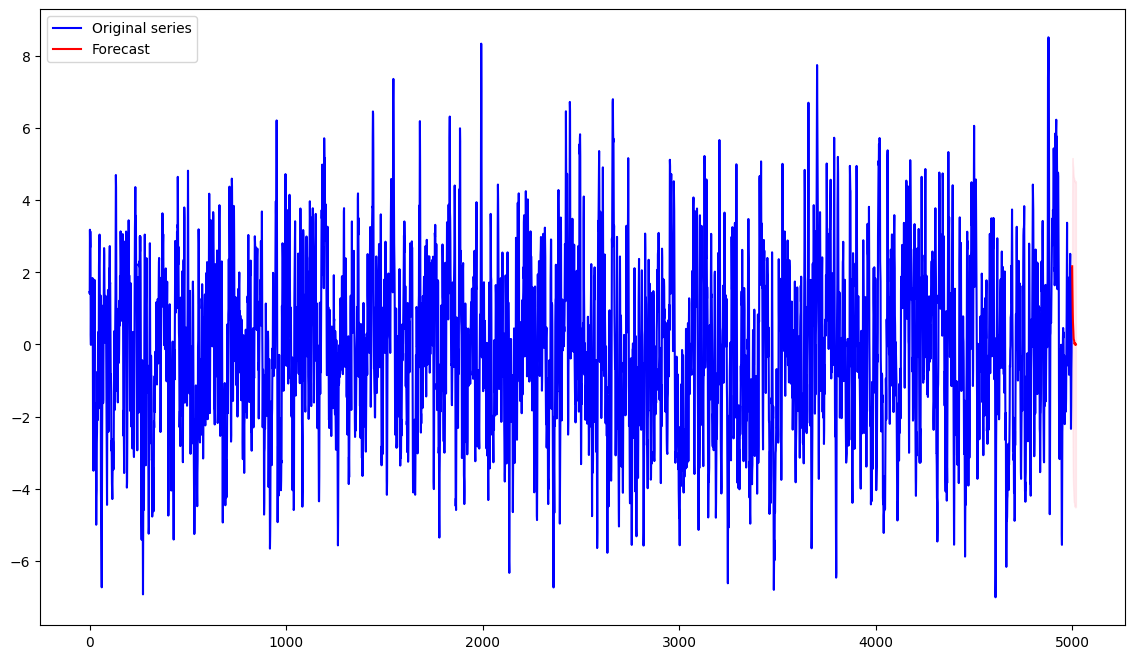

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Получаем прогноз на 20 шагов вперед
forecast_steps = 20
forecast = mdl.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Создаем индексы для прогнозируемых значений
forecast_index = pd.RangeIndex(start=len(series), stop=len(series) + forecast_steps)

# Визуализируем исходные и прогнозируемые значения
plt.figure(figsize=(14, 8))
ax = plt.axes()

# Исходные данные
ax.plot(series, label='Original series', color='blue')

# Прогнозируемые значения
ax.plot(forecast_index, forecast_mean, label='Forecast', color='red')

# Доверительный интервал
ax.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)

ax.legend()
plt.show()


## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

In [65]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

series = pd.read_csv("D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/Series/international-airline-passengers.csv")['Count']
# Обработка пропущенных значений
series = series.dropna()

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except Exception as e:
                print(f"Ошибка при модели с порядком {(i, d, j)}: {e}")
                continue

if best_mdl is not None:
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    tsplot(best_mdl.resid, lags=30)
else:
    print("Подгонка модели не удалась, допустимая модель не найдена.")


Ошибка при модели с порядком (0, 0, 0): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 0, 1): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 0, 2): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 0, 3): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 0, 4): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 0): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 1): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 2): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 3): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 4): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 2, 0): ARIMA.fit(

In [66]:
best_mdl

In [68]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

# Загружаем данные
series = pd.read_csv("D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/Series/international-airline-passengers.csv")['Count']
series = series.dropna()  # Убедитесь, что нет пропущенных значений

# Находим лучшую модель
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except Exception as e:
                print(f"Ошибка при модели с порядком {(i, d, j)}: {e}")
                continue

# Проверка и построение графиков
if best_mdl is not None:
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
else:
    print("Подгонка модели не удалась, допустимая модель не найдена.")


Ошибка при модели с порядком (0, 0, 0): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 0, 1): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 0, 2): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 0, 3): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 0, 4): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 0): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 1): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 2): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 3): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 1, 4): ARIMA.fit() got an unexpected keyword argument 'trend'
Ошибка при модели с порядком (0, 2, 0): ARIMA.fit(

Другие вариации для класса ARMA:
- SARIMA - арима с учетом сезонности
- ARIMAX/SARIMAX

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


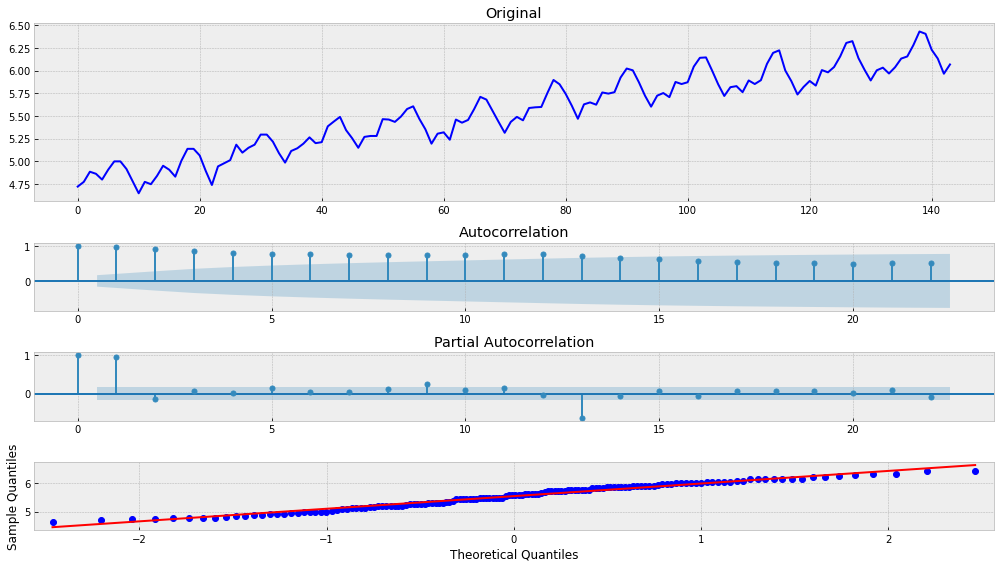

In [ ]:
series = pd.read_csv("../1. Лекция/Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
tsplot(series)

/Users/arthursaprykin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/arthursaprykin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_mod

aic: -294.55887 | order: (4, 2, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -2.257747
p-value                          0.185958
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


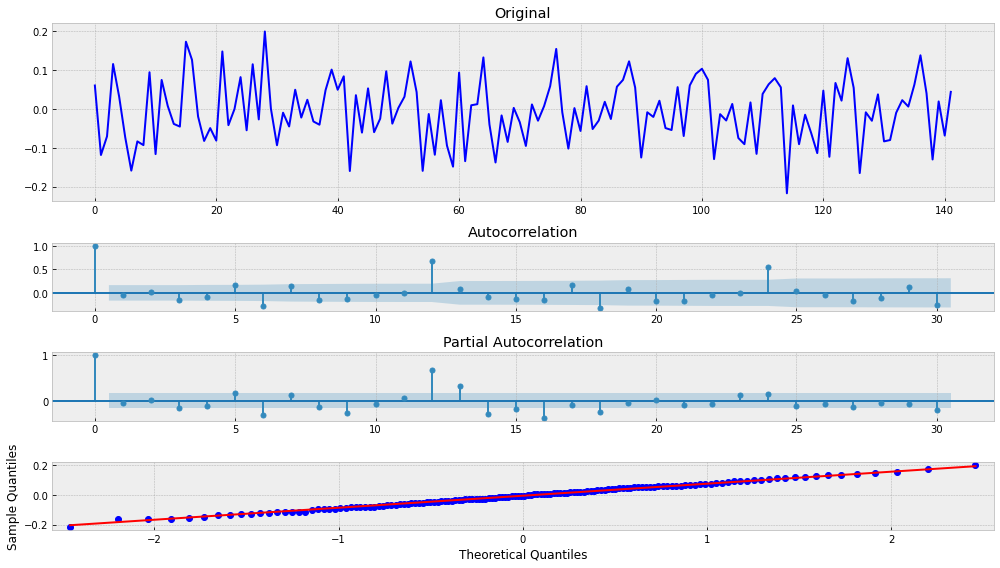

In [ ]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Results of Dickey-Fuller Test:
Test Statistic                 -31.510128
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


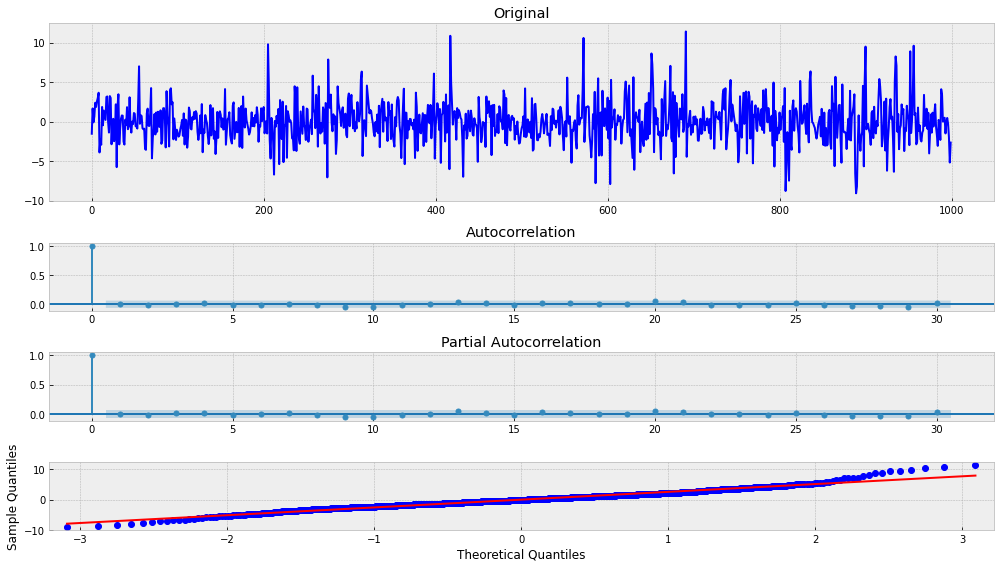

In [ ]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = 5.5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [ ]:
from arch import arch_model

## Практика! Реализуйте процесс GARCH, нарисуйте его график, примените к нему модель ARIMA и посмотрите на график остатков

In [ ]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)

In [ ]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [ ]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

In [ ]:
tsplot(mdl.resid)

Применим GARCH

In [ ]:
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [ ]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 4
o_ = 0
q_ = 4

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

In [ ]:
tsplot(res.resid)

## Проведем анализ для monthly-boston-armed-robberies-j

In [ ]:
new_series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

In [ ]:
aic, order, mdl = _get_best_model(new_series)


In [ ]:
tsplot(mdl.resid)

In [ ]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

In [ ]:
tsplot(res.resid)

## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

Генерируем большое количество фичей для нашего временного ряда

In [ ]:
series = pd.read_csv("../1. Лекция/Series/international-airline-passengers.csv")

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

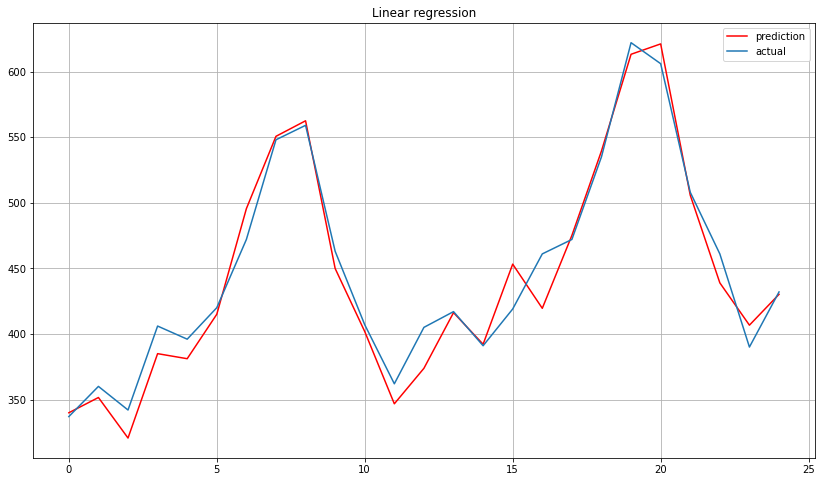

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016